# CSII 2024 Exercise 12: Q parametrization & Internal Model Control

© 2024 ETH Zurich, Jacques Bianchi, Sofia Talleri, Moritz Heppler, Felix Schnitzler, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Reference:
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- [Matlab Smith Predictor](https://ch.mathworks.com/help/control/ug/control-of-processes-with-long-dead-time-the-smith-predictor.html)
- [Smith Predictor](https://en.wikipedia.org/wiki/Smith_predictor)


## Case Study: Kitchen Oven

Kitchen ovens represent a practical and challenging control system due to their complex dynamics and sensitivity to external disturbances. Precise temperature regulation is crucial for cooking success, impacting food quality, energy efficiency, and equipment lifespan.

In this exercise, we'll delve into oven step response dynamics, implement a PI controller, and assess the benefits of integrating a Smith Predictor to enhance warm-up capabilities.


-------
# Set Up

## Installation
We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`, which can be installed using `pip`. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search.

## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.






In [ ]:
# Install the required python library with pip
!pip install control

# Import the required python libraries
from typing import Optional, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import control as ct

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 5.6 MB/s eta 0:00:00


# Task Description
A simplified transfer function for an oven can be represented as a first-order system with dead time. The transfer function can be written as:

$P_{OVEN}(s) = P(s) = P_{1}(s) \cdot e^{-sT}  = \frac{k}{\tau s + 1}\cdot e^{-sT}$

Where:

k is the steady-state gain of the oven.\
$\tau$ is the time constant, representing how fast the oven heats up or cools down. \
T is the dead time, representing the delay between changing the input (e.g., adjusting the temperature setting) and observing the effect on the output (e.g., actual temperature change).

This transfer function captures the basic dynamics of an oven, including its heating/cooling behavior and any inherent delays.

In the following task, the plant is a kitchen oven and you would like to implement a controller to preheat it to a certain temperature  $T_{\infty}$.

For controlled systems with a significant dead time, i.e. if $\frac{T}{T + \tau} > 0.3$, you cannot simply design a PID controller. Instead, you design a controller that can handle the dead time.

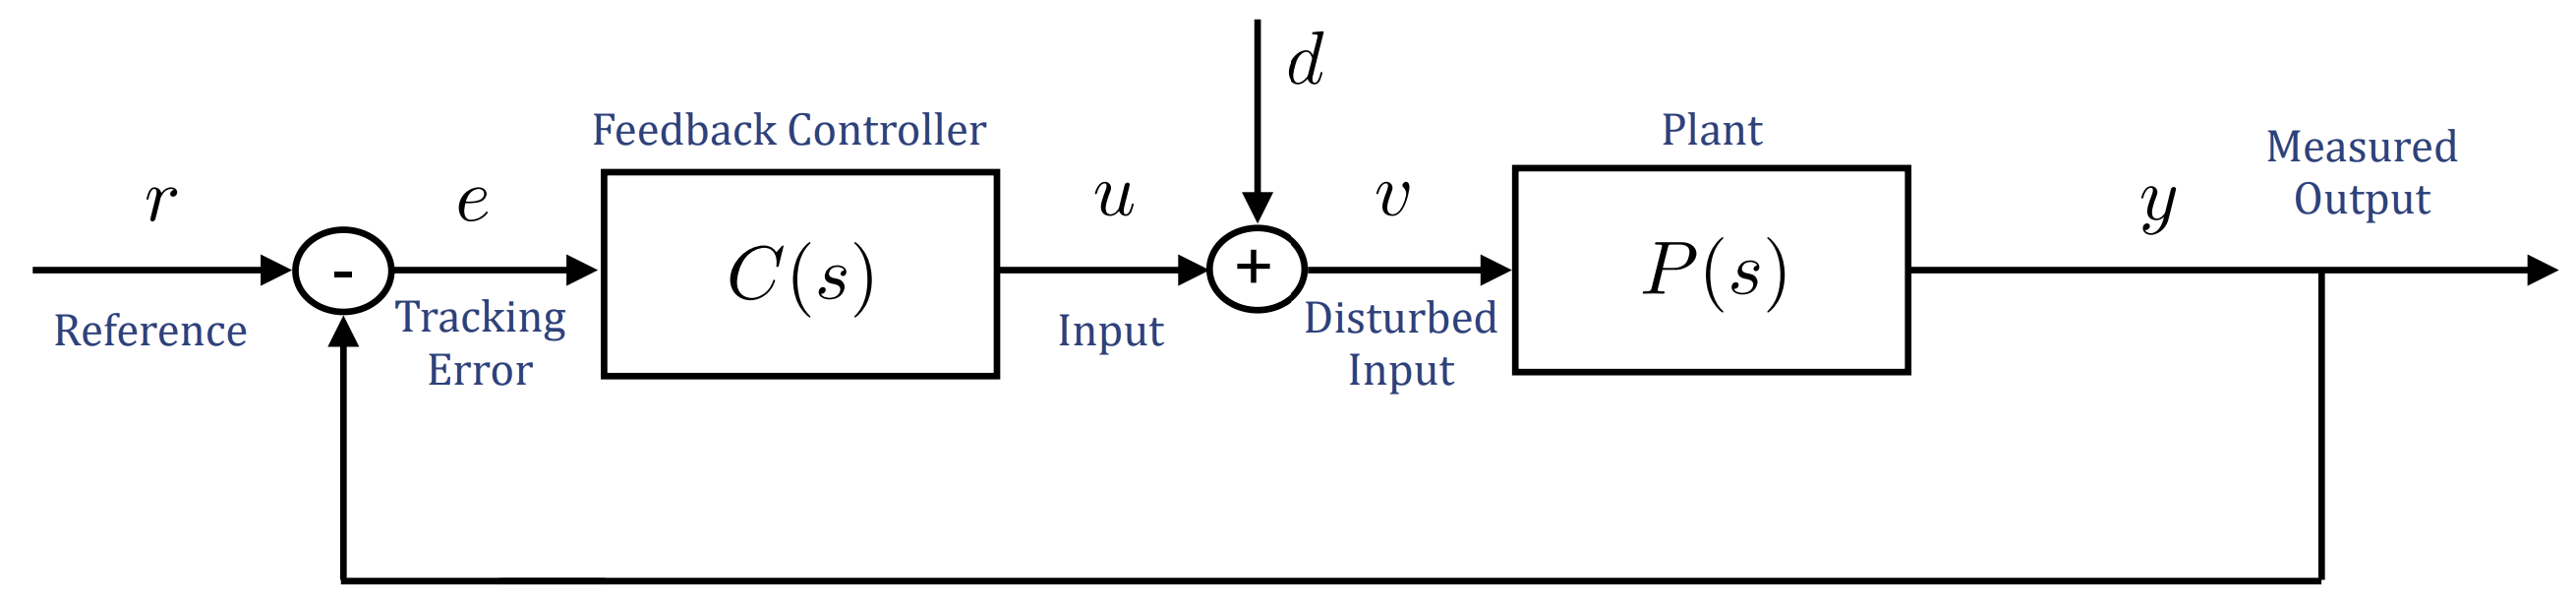


In [ ]:
k = 0.7
tau = 100
T = 60

# Task 1: PI Controller

One of your colleagues is of the opinion that it would be sufficient to design a PI controller according to the [Ziegler and Nichols rules](https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method) to achieve a satisfactory system response.

Your colleague has already determined the critical amplification $k_p^* = 1.2$ and the corresponding period duration $T^* =\frac{2 \cdot π}{\omega^∗} = 90 s$.

In [ ]:
k_critical = 0.9
T_critical = 90

Write P(s):

TRICK: Create a linear system that approximates a delay with the [Pade approximation](https://python-control.readthedocs.io/en/0.10.0/generated/control.pade.html#control.pade).

In [ ]:
# Write the system of the oven
# Define P1(s)
P_1_s = ct.TransferFunction(1, 1, name='P_1_s')

# Define the delay
# Use Pade approximation for dead time
# Higher order (n), better approximation. Use n = 10
delay = ct.TransferFunction(1, 1, name='delay')

# Define P(s)
# Include dead time in the transfer function
P_s = ct.TransferFunction(1, 1, name='P_s')

Find the parameter with the rules of Ziegler and Nichols:

In [ ]:
# Write your Ziegler and Nichols PI parameters
k_p = None
T_i = None

Write C_PI(s):

In [ ]:
#Define C(s)
C_PI_s = ct.TransferFunction(1, 1, name='C_PI_s')

Write the close loop system of your PI controller:

In [ ]:
# Define close loop T(s)
T_s = ct.TransferFunction(1, 1, name='T_s')

## Task 1: Solution


In [ ]:
# Define P1(s)
num_p_sol = [k]
den_p_sol = [tau, 1]
P_1_s_sol = ct.TransferFunction(num_p_sol, den_p_sol, name='P_1_s_sol')

# Define the delay
# Use Pade approximation for dead time
# Higher order (n), better approximation. Use n = 10
num_delay_sol, den_delay_sol = ct.pade(T, n=10)
delay_sol = ct.TransferFunction(num_delay_sol, den_delay_sol, name='delay_sol')

# Define P(s)
# Include dead time in the transfer function
P_s_sol = ct.TransferFunction(P_1_s_sol * delay_sol, name='P_s_sol')

#################################################################################
# Write your Ziegler and Nichols PI parameters
k_p_sol = 0.45 * k_critical
T_i_sol = 0.83 * T_critical

#################################################################################
#Define C(s)
num_c_sol = [k_p_sol*T_i_sol,k_p_sol]
den_c_sol = [T_i_sol,0]
C_PI_s_sol = ct.TransferFunction(num_c_sol, den_c_sol, name='C_PI_s_sol')

#################################################################################
# Define closed loop T(s)
L_s_sol = ct.TransferFunction(P_s_sol*C_PI_s_sol, name='L_s_sol')
T_s_sol = ct.TransferFunction(L_s_sol/(1+L_s_sol), name='T_s_sol')

## Test your implementation here

In [ ]:
def compare_transfer_functions(TF1, TF2):
    # Check if numerators are the same
    same_numerator = np.array_equal(TF1.num[0], TF2.num[0])

    # Check if denominators are the same
    same_denominator = np.array_equal(TF1.den[0], TF2.den[0])

    # Compare both numerators and denominators to derive the comparison outcome
    if same_numerator and same_denominator:
        return True
    else:
        return False

io_test_ex_sys = [P_1_s, delay, P_s, C_PI_s, T_s]
io_test_sol_sys = [P_1_s_sol, delay_sol, P_s_sol, C_PI_s_sol, T_s_sol]

for i in range(len(io_test_ex_sys)):
  if compare_transfer_functions(io_test_ex_sys[i], io_test_sol_sys[i]):
    print('Your Implementation is correct!')
    print(f'Solution: {io_test_ex_sys[i]}')
  else:
    print(f'Your implementation: {io_test_ex_sys[i]}')
    print(f'Solution: {io_test_sol_sys[i]}')
    break

Your implementation: <TransferFunction>: P_1_s
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


1
-
1

Solution: <TransferFunction>: P_1_s_sol
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   0.7
---------
100 s + 1



##Simulate the step response of the control system

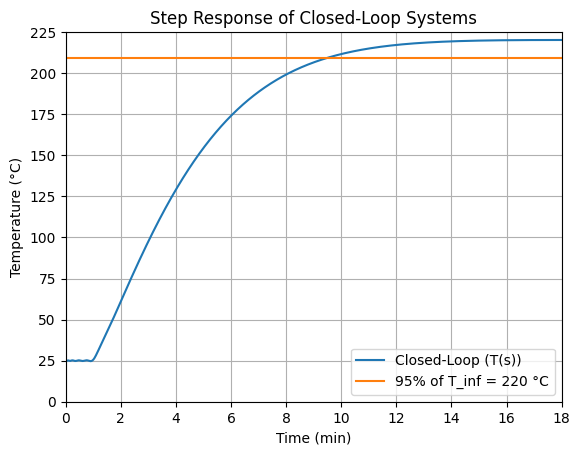

In [ ]:
# Plot your results
# Time vector for simulation
time = np.linspace(0, 60*18, 1000)
time_t, response_t = ct.step_response(T_s_sol, time)

# Apply offset to represent temperature transition
# Room temperature: 25 °C
response_t_offset = response_t * 195 + 25  # Closed-loop step from 25 to 220

# Plot the step responses
plt.figure()
plt.plot(time / 60, response_t_offset, label="Closed-Loop (T(s))")
plt.plot(time / 60, np.full_like(time, 220 * 0.95), label="95% of T_inf = 220 °C")

# Graph labels and settings
plt.title("Step Response of Closed-Loop Systems")
plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.xlim([0, 18])
plt.ylim([0, 225])
plt.grid(True)
plt.legend()
plt.show()

# Task 2: Q parametrization
Plants with delays are hard to control and the regular PID control structure
is not well suited (in particular, the D part is not useful). Instead use controllers that have a “prediction capability.”

Having taken the Control System II course, you know the Q parameterization and remember that the Q and C versions are equivalent:




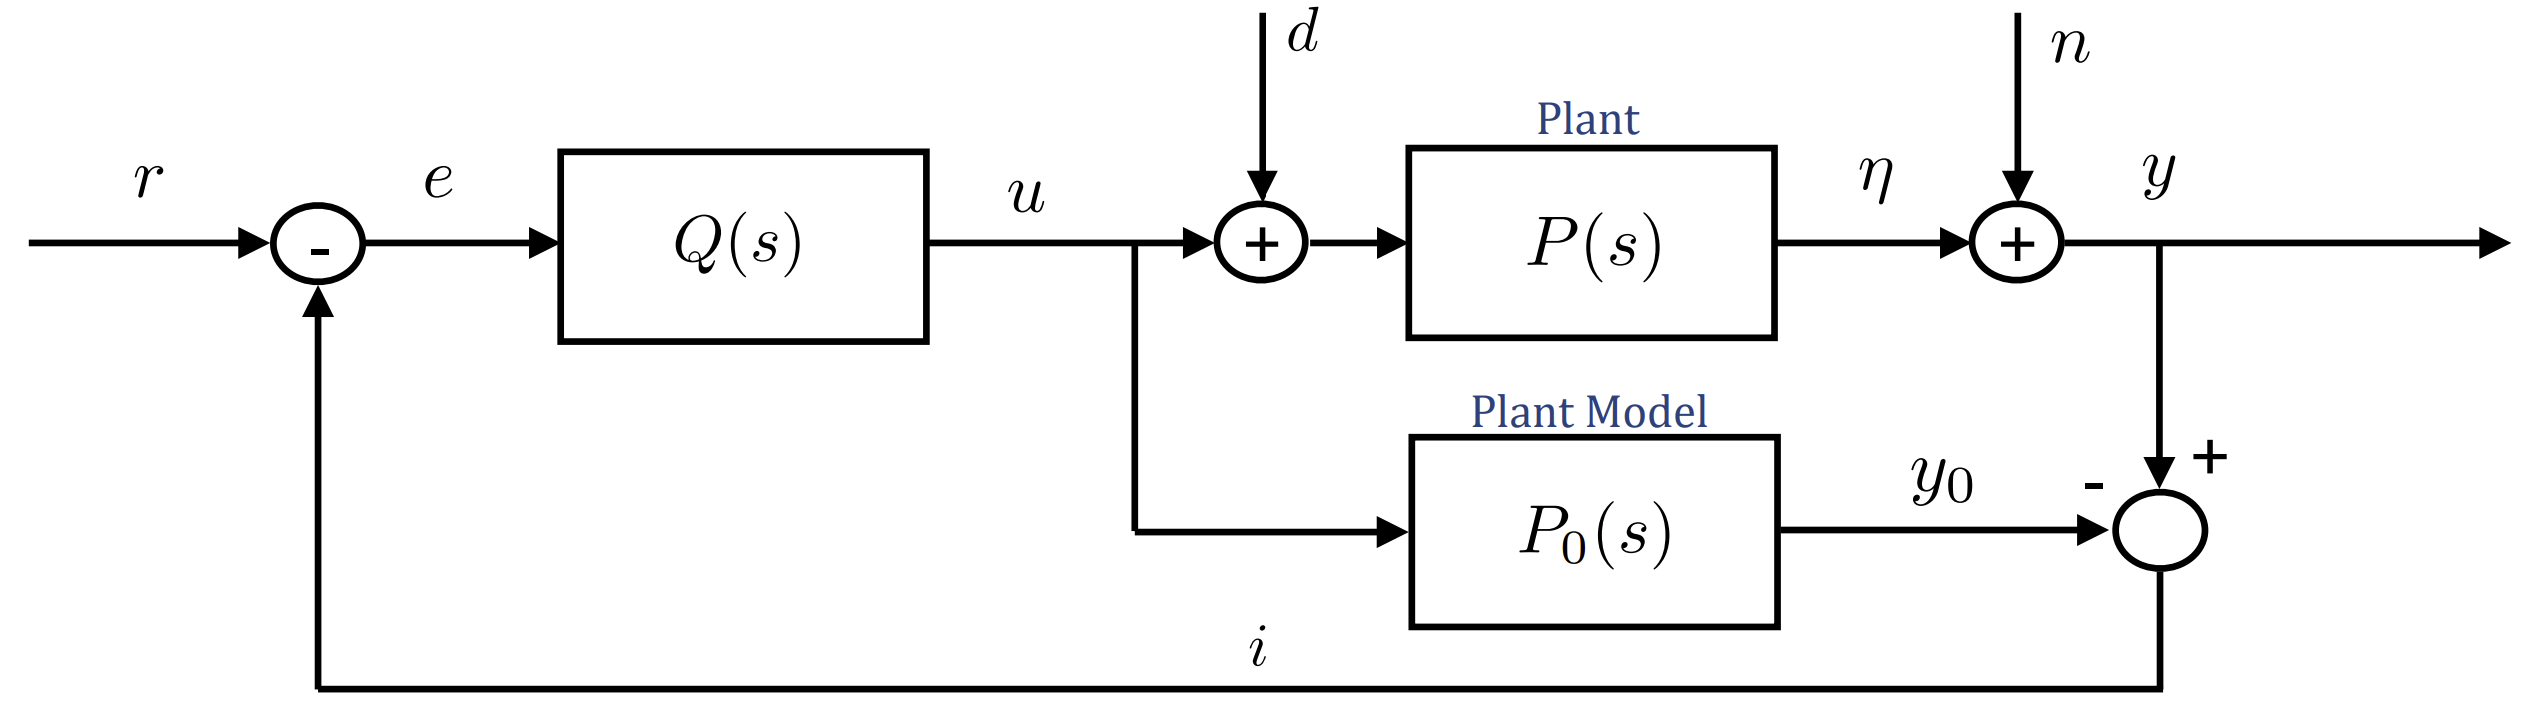

The transfer function of the control system can be represented as follows (assuming that a perfect model of the system is available, where $P(s) = P_0(s)$):

$T_{ref}(s) = T_1(s) \cdot e^{-sT} = \frac{P_1(s) \cdot Q(s)}{1 + P_1(s) \cdot Q(s)} \cdot e^{-sT}$

You searched on the internet what the ideal closed loop system of your oven should be and found that: $T_{ref}(s) = \frac{1}{90 \cdot s + 1} \cdot e^{-sT}$

Write $T_{ref}(s)$:

In [ ]:
# Write the system T_1(s)
T_1 = ct.TransferFunction(1, 1, name='T_1')
T_ref = ct.TransferFunction(1, 1, name='T_ref')

Now determine the internal controller $Q(s)$ using the above equation:

In [ ]:
Q_s = ct.TransferFunction(1, 1, name='Q_s')

## Task 2: Solution

In [ ]:
# Given parameters for Tref(s) first order
numerator_tref_sol = [1]
denominator_tref_sol = [90, 1]
T_1_sol = ct.TransferFunction(numerator_tref_sol, denominator_tref_sol, name='T_1_sol')
T_ref_sol = ct.TransferFunction(T_1_sol * delay_sol, name='T_ref_sol')

#################################################################################
# Define Q(s)
Q_s_sol = ct.TransferFunction(T_1_sol/(P_1_s_sol*(1-T_1_sol)), name='Q_s_sol')

## Test your implementation here

In [ ]:
io_test_ex_sys_2 = [T_ref, Q_s]
io_test_sol_sys_2 = [T_ref_sol, Q_s_sol]

for i in range(len(io_test_ex_sys_2)):
  if compare_transfer_functions(io_test_ex_sys_2[i], io_test_sol_sys_2[i]):
    print('Your Implementation is correct!')
    print(f'Solution: {io_test_ex_sys_2[i]}')
  else:
    print(f'Your implementation: {io_test_ex_sys_2[i]}')
    print(f'Solution: {io_test_sol_sys_2[i]}')
    break

Your implementation: <TransferFunction>: T_ref
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


1
-
1

Solution: <TransferFunction>: T_ref_sol
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


    s^10 - 1.833 s^9 + 1.65 s^8 - 0.9533 s^7 + 0.3893 s^6 - 0.1168 s^5 + 0.02595 s^4 - 0.004202 s^3 + 0.0004727 s^2 - 3.326e-05 s + 1.109e-06
-------------------------------------------------------------------------------------------------------------------------------------------------
90 s^11 + 166 s^10 + 150.3 s^9 + 87.45 s^8 + 35.99 s^7 + 10.9 s^6 + 2.452 s^5 + 0.4041 s^4 + 0.04674 s^3 + 0.003466 s^2 + 0.0001331 s + 1.109e-06



## Simulate the step response of the control system

Compare T(s) with $T_{ref}(s)$ and Q(s) with C_PI(s).

Which method gives the faster rise time?

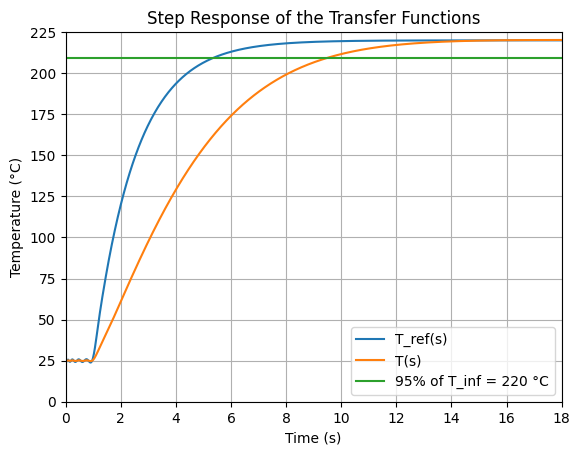

In [ ]:
# Plot your results
# Time vector for simulation
time = np.linspace(0, 60*18, 1000)
time_tref, response_tref = ct.step_response(T_ref_sol, time)
time_q, response_q = ct.step_response(Q_s_sol, time)
time_c, response_c = ct.step_response(C_PI_s_sol, time)

# Apply offset to represent temperature transition
# Room temperature: 25 °C
response_tref_offset = response_tref * 195 + 25  # Closed-loop step from 25 to 220


# Plot the step response of T_ref(s) and T(s)
plt.figure()
plt.plot(time_tref/60, response_tref_offset, label='T_ref(s)')
plt.plot(time / 60, response_t_offset, label="T(s)")
plt.plot(time / 60, np.full_like(time, 220 * 0.95), label="95% of T_inf = 220 °C")
plt.title('Step Response of the Transfer Functions')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xlim([0, 18])
plt.ylim([0, 225])
plt.legend()
plt.show()

# Task 3: Internal Model Control, Robustness to Model Mismatch

You now want to show your colleague how a [Smith Predictor](https://en.wikipedia.org/wiki/Smith_predictor) works!

In real world case the plant and the model of your plant always differ a little.
Consider different dead time and different plant models.

Plot the step response and nyquist diagram and observe what happen!

The signal flow diagram of a Smith Predictor control system is given as:

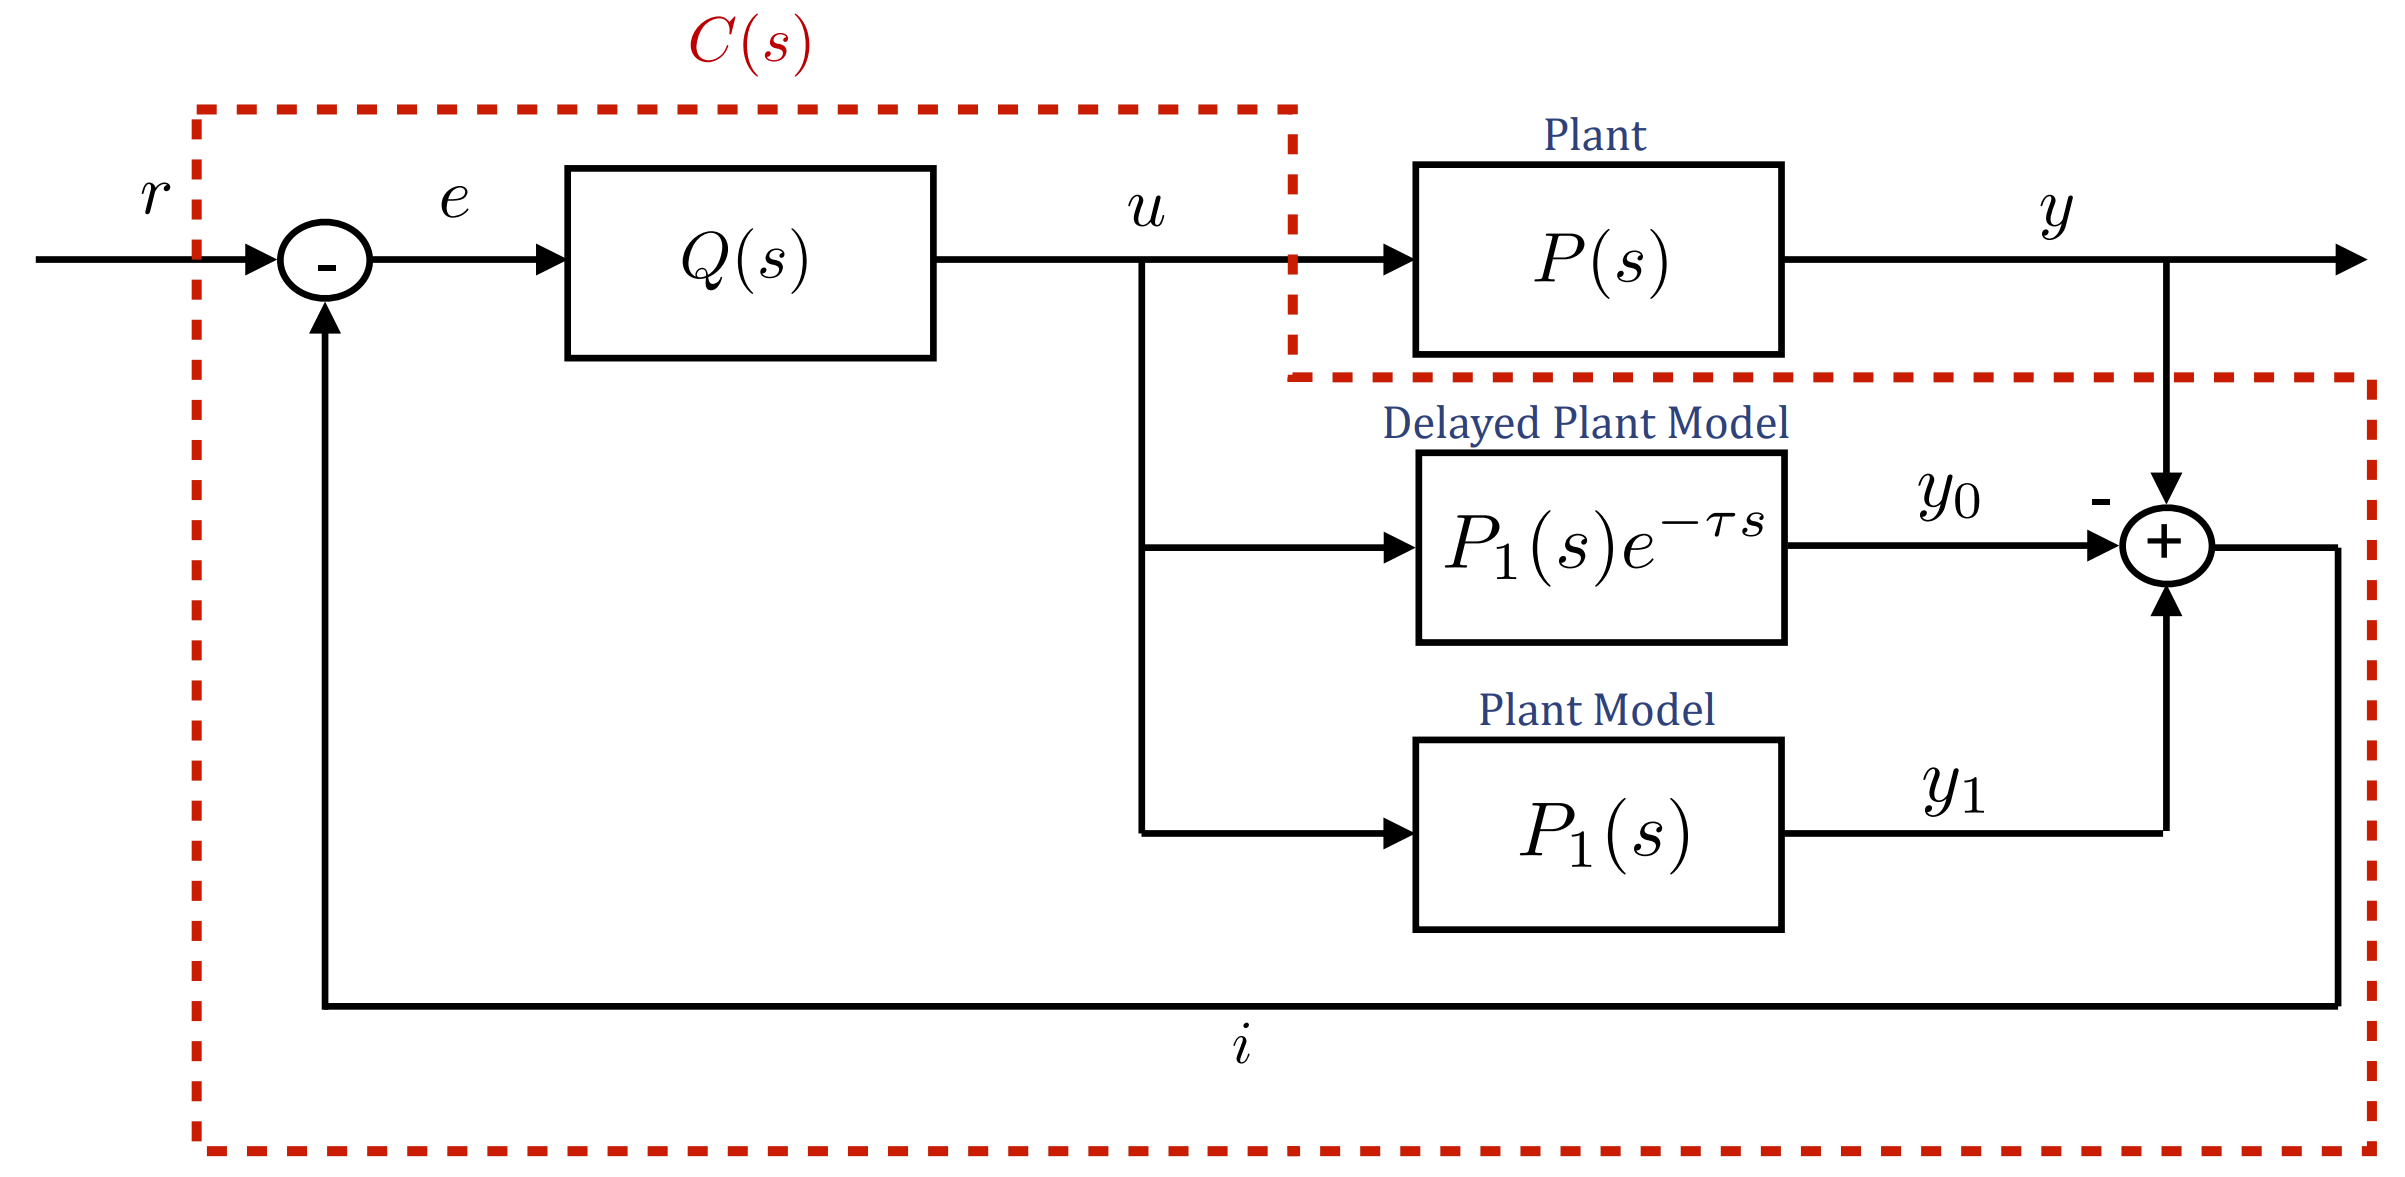

## Task 3.1: Perturbed model
We want to study the influence of uncertainty on the process dynamics and dead time. For this reason, we introduce perturbed models that differs from the real process model adopted so far.

$P_{PERTURBED_1}(s) = P_{LOW}(s) \cdot e^{-sT}  = \frac{k_1}{\tau_1 s + 1}\cdot e^{-sT}$

$P_{PERTURBED_2}(s) = P_{HIGH}(s) \cdot e^{-sT}  = \frac{k_2}{\tau_2 s + 1}\cdot e^{-sT}$

Vary the parameters k and τ and anaylize the bode plot and step response: what can you say about the influence of model error on the system?

$P_{LOW}$ and $P_{HIGH}$ are given as:

In [ ]:
k_1 = k * 0.5
k_2 = k * 1.5

tau_1 = tau * 1
tau_2 = tau * 1

In [ ]:
num_p_1 = [k_1]
den_p_1 = [tau_1, 1]
P_low = ct.TransferFunction(num_p_1, den_p_1, name='P_low')
P_perturbed_1 = ct.TransferFunction(P_low * delay_sol, name='P_perturbed_1')

num_p_2 = [k*0.9]
den_p_2 = [tau*1, 1]
P_high = ct.TransferFunction(num_p_2, den_p_2, name='P_high')
P_perturbed_2 = ct.TransferFunction(P_low * delay_sol, name='P_perturbed_2')

Write $C_1(s)$ with $P_{LOW}(s)$ and $C_2(s)$ with $P_{HIGH}$(s):

In [ ]:
#Define C(s)
C_1 = ct.TransferFunction(1, 1, name='C_1')
C_2 = ct.TransferFunction(1, 1, name='C_2')

Write $T_1(s)$ with $P_{LOW}(s)$ and $T_2(s)$ with $P_{HIGH}$(s):

In [ ]:
#Define T(s)
T_real_1 = ct.TransferFunction(1, 1, name='T_real_1')
T_real_2 = ct.TransferFunction(1, 1, name='T_real_2')

##Task 3.1: Solution

In [ ]:
#Define C(s)
C_1_sol = ct.TransferFunction(Q_s_sol/(1+Q_s_sol*P_low*(1-delay_sol)), name='C_1_sol')
C_2_sol = ct.TransferFunction(Q_s_sol/(1+Q_s_sol*P_high*(1-delay_sol)), name='C_2_sol')

#################################################################################
#Define T(s)
T_real_1_sol = ct.TransferFunction(P_s_sol*C_1_sol/(1+P_s_sol*C_1_sol), name='T_real_1_sol')
T_real_2_sol = ct.TransferFunction(P_s_sol*C_2_sol/(1+P_s_sol*C_2_sol), name='T_real_2_sol')

##Test your implementation here

In [ ]:
io_test_ex_sys_3 = [C_1, C_2, T_real_1, T_real_2]
io_test_sol_sys_3 = [C_1_sol, C_2_sol, T_real_1_sol, T_real_2_sol]

for i in range(len(io_test_ex_sys_3)):
  if compare_transfer_functions(io_test_ex_sys_3[i], io_test_sol_sys_3[i]):
    print('Your Implementation is correct!')
    print(f'Solution: {io_test_ex_sys_3[i]}')
  else:
    print(f'Your implementation: {io_test_ex_sys_3[i]}')
    print(f'Solution: {io_test_sol_sys_3[i]}')
    break

Your implementation: <TransferFunction>: C_1
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


1
-
1

Solution: <TransferFunction>: C_1_sol
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


5.103e+09 s^15 + 9.571e+09 s^14 + 8.818e+09 s^13 + 5.227e+09 s^12 + 2.198e+09 s^11 + 6.831e+08 s^10 + 1.589e+08 s^9 + 2.744e+07 s^8 + 3.409e+06 s^7 + 2.865e+05 s^6 + 1.454e+04 s^5 + 363.9 s^4 + 4.605 s^3 + 0.02864 s^2 + 6.985e-05 s
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
         3.215e+09 s^15 + 5.998e+09 s^14 + 5.561e+09 s^13 + 3.24e+09 s^12 + 1.386e+09 s^11 + 4.179e+08 s^10 + 1.001e+08 s^9 + 1.646e+07 s^8 + 2.136e+06 s^7 + 1.655e+05 s^6 + 8793 s^5 + 192.2 s^4 + 1.775 s^3 + 0.005868 s^2



##Simulate the step response of the control system

Plot the bode plot of P_low, P_1_s, P_high and T_real_1, T_ref, T_real_2

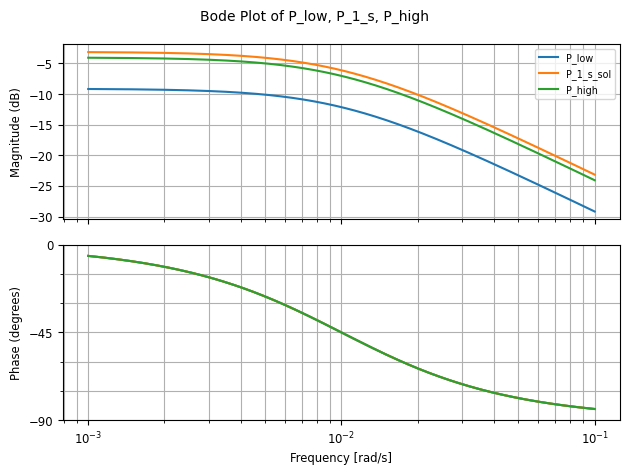

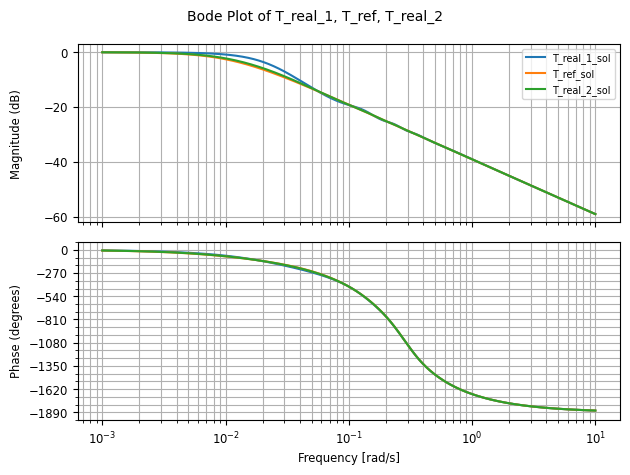

In [ ]:
#Bode plot of P_low, P_1_s, P_high
plt.figure()
ct.bode_plot(
    [P_low, P_1_s_sol, P_high],  # Systems to plot
    dB=True,  # Magnitude in dB
    deg=True,  # Phase in degrees
    plot_magnitude=True,  # Show magnitude plot
    plot_phase=True,  # Show phase plot
    magnitude_label="Magnitude (dB)",  # Custom magnitude label
    phase_label="Phase (degrees)",  # Custom phase label
    legend_loc="best",  # Location for the legend
    title="Bode Plot of P_low, P_1_s, P_high",  # Title for the plot
)
plt.show()

#Bode plot of T_real_1, T_ref, T_real_2
plt.figure()
ct.bode_plot(
    [T_real_1_sol, T_ref_sol, T_real_2_sol],  # Systems to plot
    dB=True,  # Magnitude in dB
    deg=True,  # Phase in degrees
    plot_magnitude=True,  # Show magnitude plot
    plot_phase=True,  # Show phase plot
    magnitude_label="Magnitude (dB)",  # Custom magnitude label
    phase_label="Phase (degrees)",  # Custom phase label
    legend_loc="best",  # Location for the legend
    title="Bode Plot of T_real_1, T_ref, T_real_2",  # Title for the plot
)
plt.show()

Plot the step response of your of T_real_1, T_ref, T_real_2 and compare the systems

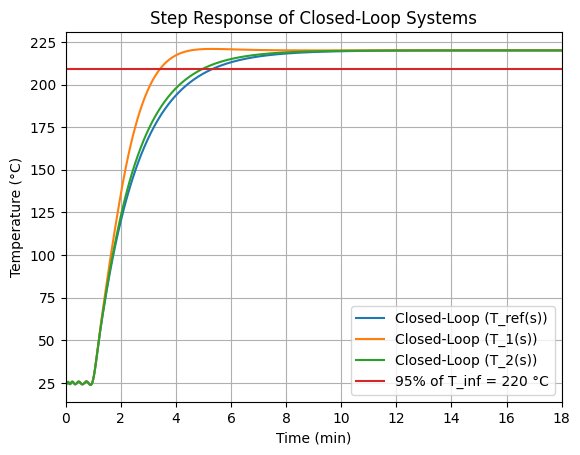

In [ ]:
# Plot your results
# Time vector for simulation
time = np.linspace(0, 60*18, 1000)
time_t, response_t = ct.step_response(T_ref_sol, time)
time_t_1_real, response_t_1_real = ct.step_response(T_real_1_sol, time)
time_t_2_real, response_t_2_real = ct.step_response(T_real_2_sol, time)

# Apply offset to represent temperature transition
# Room temperature: 25 °C
response_t_offset = response_t * 195 + 25  # Closed-loop step from 25 to 220
response_t_real_1_offset = response_t_1_real * 195 + 25  # Closed-loop step from 25 to 220
response_t_real_2_offset = response_t_2_real * 195 + 25  # Closed-loop step from 25 to 220

# Plot the step responses
plt.figure()
plt.plot(time_t / 60, response_t_offset, label="Closed-Loop (T_ref(s))")
plt.plot(time_t_1_real / 60, response_t_real_1_offset, label="Closed-Loop (T_1(s))")
plt.plot(time_t_2_real / 60, response_t_real_2_offset, label="Closed-Loop (T_2(s))")
plt.plot(time / 60, np.full_like(time, 220 * 0.95), label="95% of T_inf = 220 °C")

# Graph labels and settings
plt.title("Step Response of Closed-Loop Systems")
plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.xlim([0, 18])
plt.grid(True)
plt.legend()
plt.show()

Change the parameters k and tau and observe what happen to the system!

## Task 3.2: Dead time mismatch
Now we test the influence of dead time approximation on our system. A system with different dead time is initialized.

$P_{PERTURBED_3}(s) = P_1(s) \cdot e^{-sT_{new}}  = \frac{k}{\tau s + 1}\cdot e^{-sT_{new}}$

Change the value of the dead time and analyze the behaviour of the system step response and nyquist plot. What is the influence of different dead time approximation on the system?

In [ ]:
T_new = 0.5 * T

Write $T_{delayed}(s)$ with $P_{PERTURBED_3}(s)$:

In [ ]:
#Define T(s)
delay_3 = ct.TransferFunction(1, 1, name='delay_3')
T_delayed = ct.TransferFunction(1, 1, name='T_delayed')

##Task 3.2: Solution

In [ ]:
num_delay_3_sol, den_delay_3_sol = ct.pade(T_new, n=10)
delay_3_sol = ct.TransferFunction(num_delay_3_sol, den_delay_3_sol, name='delay_3_sol')

C_3_sol = ct.TransferFunction(Q_s_sol/(1+Q_s_sol*P_1_s_sol*(1-delay_3_sol)), name='C_3_sol')
T_delayed_sol = ct.TransferFunction(P_s_sol*C_3_sol/(1+P_s_sol*C_3_sol), name='T_delayed_sol')

##Test your implementation here

In [ ]:
if compare_transfer_functions(T_delayed, T_delayed_sol):
  print('Your Implementation is correct!')
  print(f'Solution: {T_delayed}')
else:
  print(f'Your implementation: {T_delayed}')
  print(f'Solution: {T_delayed_sol}')

Your implementation: <TransferFunction>: T_delayed
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


1
-
1

Solution: <TransferFunction>: T_delayed_sol
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       1.148e+21 s^51 + 8.519e+21 s^50 + 3.134e+22 s^49 + 7.554e+22 s^48 + 1.338e+23 s^47 + 1.846e+23 s^46 + 2.058e+23 s^45 + 1.893e+23 s^44 + 1.458e+23 s^43 + 9.465e+22 s^42 + 5.2e+22 s^41 + 2.415e+22 s^40 + 9.436e+21 s^39 + 3.073e+21 s^38 + 8.224e+20 s^37 + 1.776e+20 s^36 + 3.027e+19 s^35 + 3.998e+18 s^34 + 3.993e+17 s^33 + 2.322e+16 s^32 - 1.318e+15 s^31 + 2.951e+14 s^30 + 3.691e+14 s^29 - 9.777e+12 s^28 - 5.032e+13 s^27 - 4.116e+12 s^26 + 5.701e+12 s^25 + 1.266e+12 s^24 - 4.476e+11 s^23 - 2.086e+11 s^22 + 7.556e+09 s^21 + 2.102e+10 s^20 + 3.644e+09 s^19 - 8.938e+08 s^18 - 4.719e+08 s^17 - 5.603e+07 s^16 + 1.309e+07 s^15 + 6.368e+06 s^14 + 1.246e+06 s^13 + 1.454e+05 s^12 + 1.055e+04 s^11 + 458.5 s^10 + 12.46 s^9 + 0.2207 s^8 + 0.0026 s^7 + 2.028e-05 s^6 + 1.009e-07 s^5 + 2.908e-10 s^4 + 3.699e-

##Simulate the step response of the control system

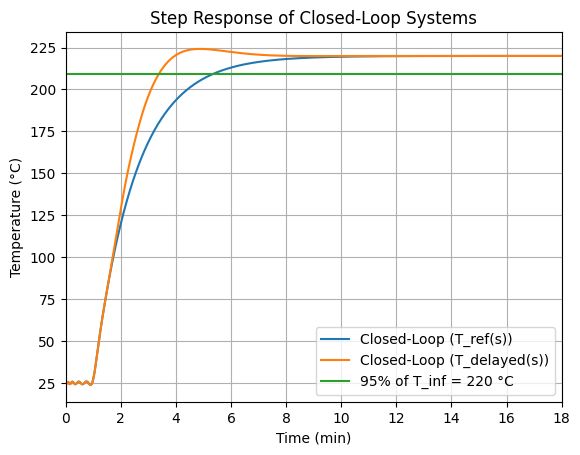

In [ ]:
# Plot your results
# Time vector for simulation
time = np.linspace(0, 60*18, 1000)
time_t, response_t = ct.step_response(T_ref_sol, time)
time_t_3_real, response_t_3_real = ct.step_response(T_delayed_sol, time)

# Apply offset to represent temperature transition
# Room temperature: 25 °C
response_t_offset = response_t * 195 + 25  # Closed-loop step from 25 to 220
response_t_real_3_offset = response_t_3_real * 195 + 25  # Closed-loop step from 25 to 220

# Plot the step responses
plt.figure()
plt.plot(time_t / 60, response_t_offset, label="Closed-Loop (T_ref(s))")
plt.plot(time_t_3_real / 60, response_t_real_3_offset, label="Closed-Loop (T_delayed(s))")
plt.plot(time / 60, np.full_like(time, 220 * 0.95), label="95% of T_inf = 220 °C")

# Graph labels and settings
plt.title("Step Response of Closed-Loop Systems")
plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.xlim([0, 18])
#plt.ylim([0, 225])
plt.grid(True)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/control/freqplot.py:1737: UserWarning: indented contour may miss closed loop pole; consider reducing indent_radius to below     0
  nyquist_responses = nyquist_response(
/usr/local/lib/python3.10/dist-packages/control/freqplot.py:1737: UserWarning: number of encirclements does not match Nyquist criterion; check frequency range and indent radius/direction
  nyquist_responses = nyquist_response(


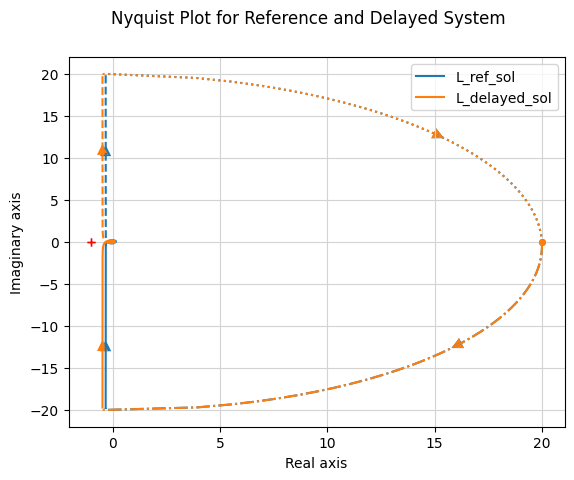

In [ ]:
# Define transfer functions for Nyquist plot
L_ref_sol = ct.TransferFunction(T_ref_sol/(1-T_ref_sol), name='L_ref_sol')
L_delayed_sol = ct.TransferFunction(T_delayed_sol/(1-T_delayed_sol), name='L_delayed_sol')

plt.figure()
ct.nyquist_plot([L_ref_sol, L_delayed_sol], title='Nyquist Plot for Reference and Delayed System' )
plt.show()

A slight variation on the dead time estimation lead still to a robust system response without excessive deviations from the reference system.

## Task 3.3: Complete model mismatch

We want to study the influence of uncertainty on the process dynamics and dead time. For this reason, we introduce perturbed models that differs from the models adopted so far.

$P_{PERTURBED}(s) = P_{new}(s) \cdot e^{-sT_{new}}  = \frac{k_{new}}{\tau_{new} \cdot s + 1}\cdot e^{-sT_{new}}$

Vary the parameters $k_{new}$ and $\tau_{new}$ and $T_{new}$ in the following snippet and anaylize the bode plot and step response: what can you say about the influence of model error on the system? Have fun!

In [ ]:
k_new = k * 1.5
tau_new = tau * 0.5
T_new = T * 0.5

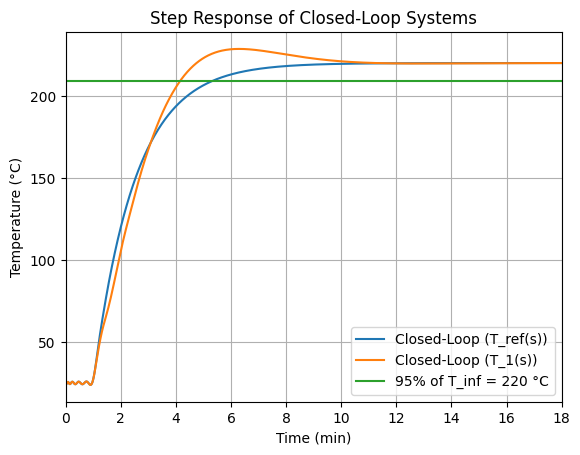

In [ ]:
#Define P(s)
num_p_new = [k_new]
den_p_new = [tau_new, 1]
P_new = ct.TransferFunction(num_p_new, den_p_new, name='P_new')
num_delay_new, den_delay_new = ct.pade(T_new, n=10)
delay_new = ct.TransferFunction(num_delay_new, den_delay_new, name='delay_new')
P_perturbed = ct.TransferFunction(P_new * delay_new, name='P_perturbed')

#Define C(s)
C_new = ct.TransferFunction(Q_s_sol/(1+Q_s_sol*P_new*(1-delay_new)), name='C_new')

#Define T(s)
T_s_new = ct.TransferFunction(P_s_sol*C_new/(1+P_s_sol*C_new), name='T_s_new')

# Plot your results
# Time vector for simulation
time = np.linspace(0, 60*18, 1000)
time_t, response_t = ct.step_response(T_ref_sol, time)
time_t_s_real, response_t_s_real = ct.step_response(T_s_new, time)

# Apply offset to represent temperature transition
# Room temperature: 25 °C
response_t_offset = response_t * 195 + 25  # Closed-loop step from 25 to 220
response_t_real_s_offset = response_t_s_real * 195 + 25  # Closed-loop step from 25 to 220

# Plot the step responses
plt.figure()
plt.plot(time_t / 60, response_t_offset, label="Closed-Loop (T_ref(s))")
plt.plot(time_t_s_real / 60, response_t_real_s_offset, label="Closed-Loop (T_1(s))")
plt.plot(time / 60, np.full_like(time, 220 * 0.95), label="95% of T_inf = 220 °C")

# Graph labels and settings
plt.title("Step Response of Closed-Loop Systems")
plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.xlim([0, 18])
plt.grid(True)
plt.legend()
plt.show()